# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

# Task Performed:
1. Apply Logistic regression on all the four vectorizers.
2. Before applying the model, please read the sklearn documentation and go through all
the parameters that it can accept and try to use some in your assignment if you think that
can help somehow
3. Performing perturbation test:
a. Get the weights W after fit your model with the data X
b. Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)
c. we fit the model again on data X' and get the weights W'
d. find the % change between W and W' ( ((|W-W'|+100) / (W+100))*100)
e. print the features whose % change is more than a threshold x, (you need to
choose this threshold using elbow method)

4. Choose different metric other than accuracy for choosing the best hyperparameter,
which is apt for imbalanced datasets and accuracy sometimes gives us false conclusions
about the model performance sometimes.
5. Do hyperparameter tuning or some feature engineering and make your model better by
reducing the false positives. (Ex: adding the length of the reviews, getting some features
from the summary column)
6. Get important features for both positive and negative classes separately.
7. Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is
recommended.
8. Avoid submitting the models which are more biased towards positive points. Try to
improve if everything or most of the points are predicting as positive.

In [150]:
import numpy 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re 
import sqlite3

In [151]:
con = sqlite3.connect("./amazon-fine-food-reviews/database.sqlite")
data = pd.read_sql_query('''
SELECT *
FROM REVIEWS
WHERE SCORE != 3''', con)
data.shape

(525814, 10)

# Data Cleaning

In [ ]:
data = data[data.HelpfulnessNumerator <= data.HelpfulnessDenominator]
data.shape

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [153]:
data['Score'] = data["Score"].apply(lambda x: "positive" if x > 3 else "negative")
sorted_data = data.sort_values('ProductId',axis = 0, inplace = False, kind = 'quicksort',ascending = True)
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138693,150511,0006641040,A1C9K534BCI9GO,Laura Purdie Salas,0,0,positive,1344211200,Charming and childlike,"A charming, rhyming book that describes the ci..."
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,negative,1129507200,awesome book poor size,This is one of the best children's books ever ...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,positive,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books..."
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,positive,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...


In [154]:
filtered_data = sorted_data.drop_duplicates(subset = {'UserId','ProfileName','Time'} ,keep = 'first', inplace = False)
filtered_data.shape

(328770, 10)

In [155]:
filtered_data['Score'].value_counts()

positive    275650
negative     53120
Name: Score, dtype: int64

In [156]:
final = filtered_data.copy()

In [157]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\manish
[nltk_data]     dogra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [158]:
stop = set(stopwords.words("english"))
st = PorterStemmer()
st.stem('burned')

'burn'

##  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [159]:
def cleanhtml(sent):
    cleanr = re.compile('<.*?>')
    cleaned = re.sub(cleanr,' ',sent)
    return cleaned
def cleanpunc(sent):
    clean = re.sub(r'[?|!|$|#|\'|"|:]',r'',sent)
    clean = re.sub(r'[,|(|)|.|\|/]',r' ',clean)
    return clean

In [160]:
i=0
all_positive_reviews =[]
all_negative_reviews = []
final_string = []
stem_data = " "
for p in final['Text'].values:
    filtered_sens = []#filtered word
    p = cleanhtml(p)
    for w in p.split():
       # print(w)
        punc = cleanpunc(w)
        for s in punc.split():
            #print(w)
            if (s.isalpha()) & (len(s)>2):
                if s.lower() not in stop:
                    stem_data = (st.stem(s.lower())).encode('utf8')
                    #can we use lemmatizer and stemming altogether??
                    filtered_sens.append(stem_data)
                    if (final['Score'].values)[i] == 'positive':
                        all_positive_reviews.append(stem_data)
                    if (final['Score'].values)[i] == 'negative':
                        all_negative_reviews.append(stem_data)
                else:
                    continue
            else:
                continue
    #print(filtered_sens)
    str1 = b" ".join(filtered_sens)
    #print(str1)
    final_string.append(str1)
    i+=1

In [161]:
final['CleanedText'] = final_string
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138693,150511,0006641040,A1C9K534BCI9GO,Laura Purdie Salas,0,0,positive,1344211200,Charming and childlike,"A charming, rhyming book that describes the ci...",b'charm rhyme book describ circumst eat dont c...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,negative,1129507200,awesome book poor size,This is one of the best children's books ever ...,b'one best children book ever written mini ver...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,positive,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",b'daughter love realli rosi book introduc real...
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,positive,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...,b'summari young boy describ use chicken soup r...


In [162]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [163]:
final = final.sort_values('Time',axis= 0,inplace = False , na_position = 'last',ascending = True)
X = final['CleanedText'].values
X = X[:100000]
y = final['Score'].values
y = y[:100000]

In [164]:
X_train ,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,stratify = y)

# Logistic regression on bow

In [165]:
count_vect = CountVectorizer() #in scikit-learn
bow_train = count_vect.fit_transform(X_train)
bow_test = count_vect.transform(X_test)
#count_vect.get_feature_names()
bow_train.shape

(70000, 32539)

In [166]:
import numpy as np

In [167]:
x = np.random.normal(loc = 0 , scale = 0.1,size = 50)
param_distb =  {'C': [y for y in x if y >0  ]}
print(param_distb)

{'C': [0.16698275797096984, 0.11398056947443365, 0.076115220379598142, 0.17229256023059686, 0.027907564007266322, 0.066047061540247629, 0.017807903972506894, 0.0031991558659850423, 0.006525179239134149, 0.11504336398450735, 0.017970785538968106, 0.015577283888338659, 0.028379520274582549, 0.15682816393394053, 0.045687225669993524, 0.056541521764899655, 0.1314026855004789, 0.047455632742603837, 0.051550262477658176, 0.17422332503357488, 0.064818656695836085, 0.13720030020819388, 0.10988625309647977, 0.10114463373321468, 0.064679822096676692, 0.014860127257105109, 0.07087264327765079, 0.094597354879467896, 0.04957879513728862]}


In [168]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
model_random = RandomizedSearchCV(LogisticRegression(class_weight = 'balanced',penalty = 'l1'),param_distb,cv = 10 ,scoring = 'accuracy')
model_random.fit(bow_train,y_train)
print(model_random.best_estimator_)
pred = model_random.predict(bow_test)
print('Accuracy ',accuracy_score(y_test,pred)*100)

LogisticRegression(C=0.17422332503357488, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy  88.2033333333


In [169]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       0.52      0.84      0.64      3811
   positive       0.97      0.89      0.93     26189

avg / total       0.92      0.88      0.89     30000



In [170]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
print('RECALL SCORE')
print(recall_score(y_test,pred,pos_label = 'positive'))
print(recall_score(y_test,pred,pos_label= 'negative') )
print('\n')
print('PRECISION SCORE')
print(precision_score(y_test,pred,pos_label = 'positive'))
print(precision_score(y_test,pred,pos_label = 'negative'))

RECALL SCORE
0.887853679026
0.842036210968


PRECISION SCORE
0.97476314245
0.522128213472


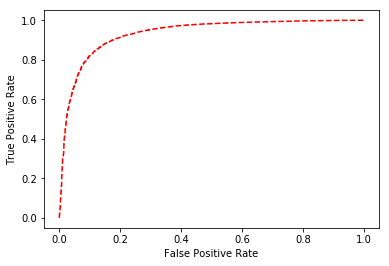

In [171]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred = model_random.predict_proba(bow_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [172]:
print(roc_auc_score(y_true,y_pred))

0.932468206735


[[ 3209   602]
 [ 2937 23252]]


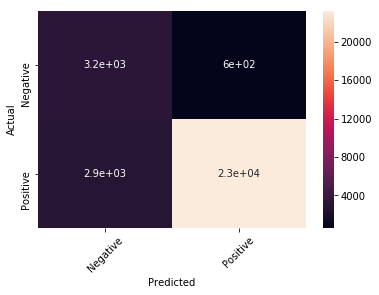

In [173]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<h3>Logistic Regression on BOW with L1</h3>
* Optimal C = 0.174
* Accuracy = 88.203
* Precision = 0.974(positive), 0.522(negative)
* Recall = 0.887 ,0.842
* AUC = 0.932
* TN = 3209
* TP = 23252


In [174]:
clf = LogisticRegression(penalty = 'l1', C = 0.1,class_weight = 'balanced')
clf.fit(bow_train,y_train)
pred = clf.predict(bow_test)
pred_train = clf.predict(bow_train)
test_error = 1-accuracy_score(y_test,pred)
train_error = 1-accuracy_score(y_train,pred_train)

In [175]:
print('Error on test',test_error*100)
print('Error on train',train_error*100)
w = clf.coef_
print('Sparsity',np.count_nonzero(w)-len(w))

Error on test 12.2433333333
Error on train 11.3757142857
Sparsity 1275


In [176]:
clf = LogisticRegression(penalty = 'l1', C = 1,class_weight = 'balanced')
clf.fit(bow_train,y_train)
pred = clf.predict(bow_test)
pred_train = clf.predict(bow_train)
test_error = 1-accuracy_score(y_test,pred)
train_error = 1-accuracy_score(y_train,pred_train)

In [177]:
print('Error on test',test_error*100)
print('Error on train',train_error*100)
w = clf.coef_
print('Sparsity',np.count_nonzero(w)-len(w))

Error on test 10.7066666667
Error on train 6.48571428571
Sparsity 5098


In [178]:
clf = LogisticRegression(penalty = 'l1', C = 10,class_weight = 'balanced')
clf.fit(bow_train,y_train)
pred = clf.predict(bow_test)
pred_train = clf.predict(bow_train)
test_error = 1-accuracy_score(y_test,pred)
train_error = 1-accuracy_score(y_train,pred_train)

In [179]:
print('Error on test',test_error*100)
print('Error on train',train_error*100)
w = clf.coef_
print('Sparsity',np.count_nonzero(w)-len(w))

Error on test 11.0633333333
Error on train 2.44857142857
Sparsity 9747


# Result with L1
1. C = 0.1 , ERROR ON TEST - 12.24 , ERROR IN TRAIN - 11.375 , SPARSITY - 1275
2. C = 1 , ERROR ON TEST - 10.7 , ERROR IN TRAIN - 6.48 , SPARSITY - 5048
3. C = 10 , ERROR ON TEST - 11.06 , ERROR IN TRAIN - 2.448 , SPARSITY - 9747

In [180]:
tunned_param = [{'C' : [10** -4, 10**-3,10**-2,10**-1,1,10,100,1000,10000]}]
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
model  = GridSearchCV(LogisticRegression(class_weight = 'balanced'),tunned_param , scoring = 'accuracy',cv = 10,n_jobs = -1)
model.fit(bow_train,y_train)
print(model.best_estimator_)
pred = model.predict(bow_test)
print('Accuracy ',accuracy_score(y_test,pred)*100)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy  89.54


In [181]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       0.56      0.78      0.66      3811
   positive       0.97      0.91      0.94     26189

avg / total       0.92      0.90      0.90     30000



In [182]:
from sklearn.metrics import recall_score , precision_score , roc_auc_score ,roc_curve
print('RECALL SCORE')
print(recall_score(y_test,pred,pos_label = 'positive'))
print(recall_score(y_test,pred,pos_label= 'negative') )
print('\n')
print('PRECISION SCORE')
print(precision_score(y_test,pred,pos_label = 'positive'))
print(precision_score(y_test,pred,pos_label = 'negative'))

RECALL SCORE
0.911756844477
0.782996588822


PRECISION SCORE
0.96652499494
0.563550519358


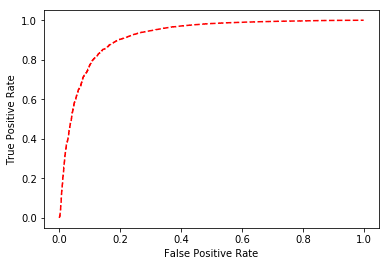

In [183]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred = model.predict_proba(bow_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [184]:
print(roc_auc_score(y_true,y_pred))

0.920404717222


[[ 2984   827]
 [ 2311 23878]]


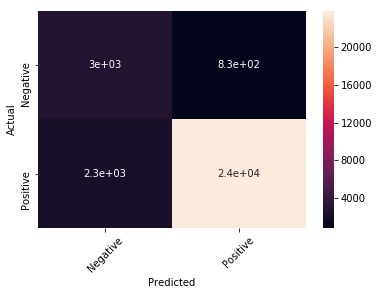

In [185]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<h3>Logistic Regression on BOW with L2</h3>
* Optimal C = 1
* Accuracy = 89.84
* Precision = 0.96(positive), 0.56(negative)
* Recall = 0.91 ,0.78
* AUC = 0.92
* TN = 2984
* TP = 23878


In [186]:
clf = LogisticRegression(class_weight = 'balanced',C = 1)
clf.fit(bow_train,y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [187]:
w = clf.coef_
print(w)

[[ -6.92004818e-03   7.78286830e-02   5.95620395e-06 ...,   9.93296045e-02
   -7.35283969e-02   3.43243715e-05]]


# Multicollinearity check

In [188]:
rand = np.random.normal(loc = 0,scale = 0.01, size = 1)
bow_train.data = bow_train.data + rand

In [190]:
mod  = GridSearchCV(LogisticRegression(class_weight = 'balanced'),tunned_param , scoring = 'accuracy',cv = 10,n_jobs = -1)
mod.fit(bow_train,y_train)
print(model.best_estimator_)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [191]:
clf_noise = LogisticRegression(class_weight = 'balanced',C = 1)
clf_noise.fit(bow_train,y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [192]:
w_noise = clf_noise.coef_
print(w_noise)

[[ -6.94135146e-03   7.83005056e-02   6.15526665e-06 ...,   9.97149823e-02
   -7.36787442e-02   3.34816168e-05]]


In [193]:
per =((w_noise[0] - w[0])/abs(w[0]))
per = abs(per)
len_per = len(per)
change = []
for i in per:
    if i > 0.3:
         change.append(i)
len_change = len(change)

In [195]:
print(len_per)
print(len_change)
print('Multicollinearity exists in features for change greater than 30% is',(len_change/len_per)*100,'%')

32539
2100
Multicollinearity exists in features for change greater than 30% is 6.453793908847843 %


In [196]:
change = []
for i in per:
    if i > 0.4:
         change.append(i)
len_change = len(change)

In [198]:
print(len_per)
print(len_change)
print('Multicollinearity exists in features for change greater than 40% is',(len_change/len_per)*100,'%')

32539
1954
Multicollinearity exists in features for change greater than 40% is 6.005101570423185 %


<h4>Top 10 Features</h4>

In [199]:
indices = w.argsort()[::-1][:10]
print(np.take(count_vect.get_feature_names(),indices))

[['worst' 'perricon' 'secondli' ..., 'skeptic' 'downsid' 'pleasantli']]


# Logistic regression on tfidf

In [200]:
tfidf_vect = TfidfVectorizer()
tfidf_train = tfidf_vect.fit_transform (X_train)
tfidf_test = tfidf_vect.transform(X_test)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean = False)
X_tr = sc.fit_transform(tfidf_train)
X_te = sc.transform(tfidf_test)
param = [{'C':[10**i for i in range(-3,4)]}]
gd = GridSearchCV(LogisticRegression(class_weight = 'balanced',penalty = 'l1'),param,cv = 10, scoring = 'accuracy',n_jobs = -1)
gd.fit(X_tr,y_train)
print(gd.best_estimator_)
pred = gd.predict(X_te)
print('Accuracy is ',accuracy_score(y_test,pred)*100)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy is  89.4066666667


In [201]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))
print('\n')
print('Recall for positive',recall_score(y_test,pred,pos_label = 'positive'))
print('Recall for negative',recall_score(y_test,pred,pos_label = 'negative'))
print('\n')
print('Precision for postive',precision_score(y_test,pred,pos_label = 'positive'))
print('Precision for negative',precision_score(y_test,pred,pos_label = 'negative'))


             precision    recall  f1-score   support

   negative       0.56      0.81      0.66      3811
   positive       0.97      0.91      0.94     26189

avg / total       0.92      0.89      0.90     30000



Recall for positive 0.906869296269
Recall for negative 0.806087641039


Precision for postive 0.96982318592
Precision for negative 0.557430593359


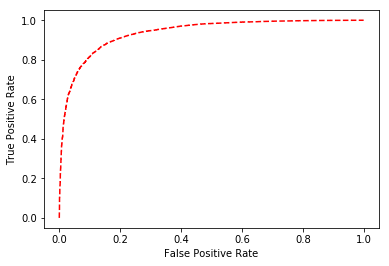

In [202]:
y_pred = gd.predict_proba(X_te)[:,1]
fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

ROC Score 0.936580162457


[[ 3072   739]
 [ 2439 23750]]


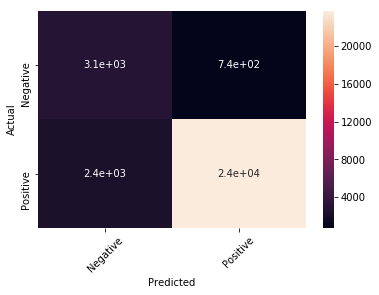

In [203]:
print('ROC Score',roc_auc_score(y_true,y_pred))
print('\n')
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<h3>Logistic Regression on Tfidf with L1</h3>
* Optimal C = 0.01
* Accuracy = 89.4
* Precision = 0.96(positive), 0.55(negative)
* Recall = 0.90 ,0.8
* AUC = 0.93
* TN = 3072
* TP = 23750


In [204]:
lr_clf = LogisticRegression(penalty = 'l1', C = 0.1,class_weight = 'balanced')
lr_clf.fit(X_tr,y_train)
pred = lr_clf.predict(X_te)
pred_train = lr_clf.predict(X_tr)
test_error = 1-accuracy_score(y_test,pred)
train_error = 1-accuracy_score(y_train,pred_train)

In [205]:
print('Error on test',test_error*100)
print('Error on train',train_error*100)
w = lr_clf.coef_
print('Sparsity',np.count_nonzero(w)-len(w))

Error on test 11.65
Error on train 2.64428571429
Sparsity 12879


In [206]:
lr_clf = LogisticRegression(penalty = 'l1', C = 1,class_weight = 'balanced')
lr_clf.fit(X_tr,y_train)
pred = lr_clf.predict(X_te)
pred_train = lr_clf.predict(X_tr)
test_error = 1-accuracy_score(y_test,pred)
train_error = 1-accuracy_score(y_train,pred_train)

In [207]:
print('Error on test',test_error*100)
print('Error on train',train_error*100)
w = lr_clf.coef_
print('Sparsity',np.count_nonzero(w)-len(w))

Error on test 13.65
Error on train 1.79571428571
Sparsity 14055


In [208]:
lr_clf = LogisticRegression(penalty = 'l1', C = 10,class_weight = 'balanced')
lr_clf.fit(X_tr,y_train)
pred = lr_clf.predict(X_te)
pred_train = lr_clf.predict(X_tr)
test_error = 1-accuracy_score(y_test,pred)
train_error = 1-accuracy_score(y_train,pred_train)

In [209]:
print('Error on test',test_error*100)
print('Error on train',train_error*100)
w = lr_clf.coef_
print('Sparsity',np.count_nonzero(w)-len(w))

Error on test 14.3666666667
Error on train 1.58714285714
Sparsity 14596


In [210]:
lr_clf = LogisticRegression(penalty = 'l1', C = 100,class_weight = 'balanced')
lr_clf.fit(X_tr,y_train)
pred = lr_clf.predict(X_te)
pred_train = lr_clf.predict(X_tr)
test_error = 1-accuracy_score(y_test,pred)
train_error = 1-accuracy_score(y_train,pred_train)

In [211]:
print('Error on test',test_error*100)
print('Error on train',train_error*100)
w = lr_clf.coef_
print('Sparsity',np.count_nonzero(w)-len(w))

Error on test 14.5733333333
Error on train 1.55714285714
Sparsity 15651


# Result with L1
1. C = 0.1 , ERROR ON TEST - 11.65 , ERROR IN TRAIN - 2.64 , SPARSITY - 12879
2. C = 1 , ERROR ON TEST - 13.65 , ERROR IN TRAIN - 1.79 , SPARSITY - 14055
3. C = 10 , ERROR ON TEST - 14.3 , ERROR IN TRAIN - 1.5 , SPARSITY - 14596
4. C = 100 , ERROR ON TEST - 14.57 , ERROR IN TRAIN - 1.55 , SPARSITY - 15651

In [212]:
model  = GridSearchCV(LogisticRegression(class_weight = 'balanced'),tunned_param , scoring = 'accuracy',cv = 10,n_jobs = -1)
model.fit(X_tr,y_train)
print(model.best_estimator_)
pred = model.predict(X_te)
print('Accuracy ',accuracy_score(y_test,pred)*100)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy  89.53


In [213]:
print(classification_report(y_test,pred))
print('\n')
print('Recall for positive',recall_score(y_test,pred,pos_label = 'positive'))
print('Recall for negative',recall_score(y_test,pred,pos_label = 'negative'))
print('\n')
print('Precision for postive',precision_score(y_test,pred,pos_label = 'positive'))
print('Precision for negative',precision_score(y_test,pred,pos_label = 'negative'))

             precision    recall  f1-score   support

   negative       0.56      0.78      0.66      3811
   positive       0.97      0.91      0.94     26189

avg / total       0.92      0.90      0.90     30000



Recall for positive 0.911604108595
Recall for negative 0.783258987142


Precision for postive 0.966558704453
Precision for negative 0.56320754717


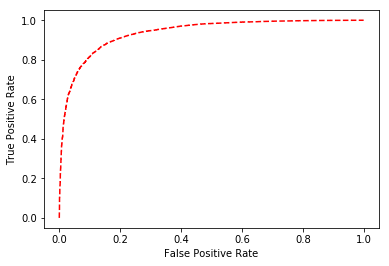

In [214]:
y_pred = gd.predict_proba(X_te)[:,1]
fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

ROC Score 0.936580162457


[[ 2985   826]
 [ 2315 23874]]


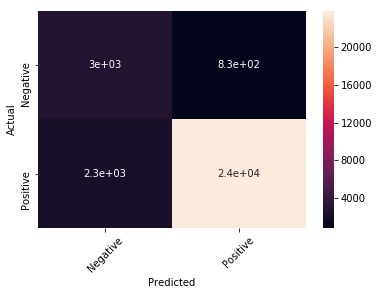

In [215]:
print('ROC Score',roc_auc_score(y_true,y_pred))
print('\n')
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<h3>Logistic Regression on Tfidf with L2</h3>
* Optimal C = 1
* Accuracy = 89.53
* Precision = 0.96(positive), 0.56(negative)
* Recall = 0.91 ,0.78
* AUC = 0.93
* TN = 2985
* TP = 23874


In [216]:
clf = LogisticRegression(C = 1 ,class_weight = 'balanced')
clf.fit(X_tr,y_train)
w_tfidf = clf.coef_
print(w_tfidf)
X_tr.data = X_tr.data + rand

[[ -1.25793095e-02   1.76258923e-02  -1.30055807e-04 ...,   8.56353978e-03
   -2.51499143e-02  -3.01451572e-05]]


# Multicollinearity check

In [217]:
mod  = GridSearchCV(LogisticRegression(class_weight = 'balanced'),tunned_param , scoring = 'accuracy',cv = 10,n_jobs = -1)
mod.fit(X_tr,y_train)
print(model.best_estimator_)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [218]:
clf_noise = LogisticRegression(class_weight = 'balanced',C = 1)
clf_noise.fit(X_tr,y_train)
w_d = clf_noise.coef_
print(w_d)

[[ -1.25791645e-02   1.78795801e-02  -1.11783373e-05 ...,   8.55776575e-03
   -2.55559428e-02   2.79360564e-06]]


In [219]:
tf_per = ((w_d - w_tfidf)/abs(w_tfidf))
tf_per = abs(tf_per)[0]
ch_tfidf = []
for i in tf_per:
    if i > 0.3:
        ch_tfidf.append(i)

In [221]:
print(len(ch_tfidf))
print(len(tf_per))
print(print('Multicollinearity exists in features for change greater than 30% is',(len(ch_tfidf)/len(tf_per))*100,'%'))

9564
32539
Multicollinearity exists in features for change greater than 30% is 29.392421402009894 %
None


In [222]:
ch_tfidf = []
for i in tf_per:
    if i > 0.4:
        ch_tfidf.append(i)

In [224]:
print(len(ch_tfidf))
print(len(tf_per))
print(print('Multicollinearity exists in features for change greater than 40% is',(len(ch_tfidf)/len(tf_per))*100,'%'))

9357
32539
Multicollinearity exists in features for change greater than 40% is 28.75626171670918 %
None


<h4>Top 10 Features</h4>

In [225]:
index = w_tfidf.argsort()[::-1][:10]
print(np.take(tfidf_vect.get_feature_names(),index))

[['worst' 'disappoint' 'tast' ..., 'highli' 'love' 'great']]


# Logistic Regression on Avg W2Vec

In [226]:
list_of_sent_train = []
for i in X_train:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_train.append(sent)

In [227]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(list_of_sent_train,min_count = 5,size = 50,workers = 4)
sent_vectors_train = []
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    sent_vec /= cnt_word
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))

70000


In [228]:
list_of_sent_test = []
for i in X_test:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_test.append(sent)

In [229]:
import warnings
warnings.filterwarnings("ignore")
from gensim.models import Word2Vec
w2v_model = Word2Vec(list_of_sent_test,min_count = 5,size = 50,workers = 4)
sent_vectors_test = []
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    sent_vec /= cnt_word
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))

30000


In [230]:
np.where(np.isnan(sent_vectors_test))

(array([], dtype=int64), array([], dtype=int64))

In [231]:
sc = StandardScaler()
w2v_train = sc.fit_transform(sent_vectors_train)
w2v_test = sc.transform(sent_vectors_test)
param = [{'C':[10**i for i in range(-3,4)]}]
w2v_model = GridSearchCV(LogisticRegression(class_weight = 'balanced',penalty = 'l1'),param,scoring = 'accuracy',cv = 10,n_jobs = -1,)
w2v_model.fit(w2v_train,y_train)
print(w2v_model.best_estimator_)
pred = w2v_model.predict(w2v_test)
acc = accuracy_score(y_test,pred)
print('accuracy is',acc*100)

LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
accuracy is 87.6833333333


In [232]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))
print('\n')
print('Recall for positive',recall_score(y_test,pred,pos_label = 'positive'))
print('Recall for negative',recall_score(y_test,pred,pos_label = 'negative'))
print('\n')
print('Precision for postive',precision_score(y_test,pred,pos_label = 'positive'))
print('Precision for negative',precision_score(y_test,pred,pos_label = 'negative'))


             precision    recall  f1-score   support

   negative       0.52      0.49      0.50      3811
   positive       0.93      0.93      0.93     26189

avg / total       0.87      0.88      0.88     30000



Recall for positive 0.933483523617
Recall for negative 0.487536079769


Precision for postive 0.926022727273
Precision for negative 0.516111111111


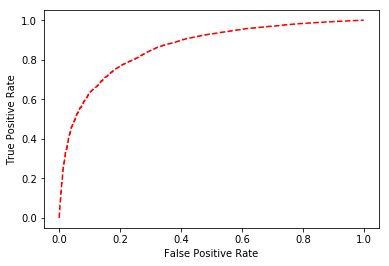

In [233]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred = w2v_model.predict_proba(w2v_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

ROC Score 0.862073848079


[[ 1858  1953]
 [ 1742 24447]]


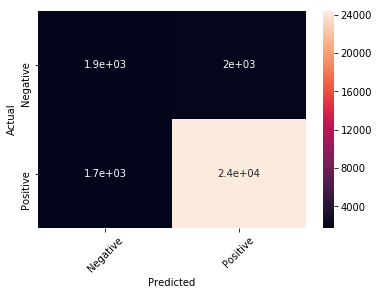

In [234]:
print('ROC Score',roc_auc_score(y_true,y_pred))
print('\n')
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<h3>Logistic Regression on Avg-w2vec with L1</h3>
* Optimal C = 10
* Accuracy = 87.68
* Precision = 0.92(positive), 0.51(negative)
* Recall = 0.93 ,0.48
* AUC = 0.86
* TN = 1858
* TP = 24447


In [235]:
lr_clf = LogisticRegression(penalty = 'l1', C = 0.1,class_weight = 'balanced')
lr_clf.fit(w2v_train,y_train)
pred = lr_clf.predict(w2v_test)
pred_train = lr_clf.predict(w2v_train)
test_error = 1-accuracy_score(y_test,pred)
train_error = 1-accuracy_score(y_train,pred_train)

In [236]:
print('Error on test',test_error*100)
print('Error on train',train_error*100)
w = lr_clf.coef_
print('Sparsity',np.count_nonzero(w)-len(w))

Error on test 13.1233333333
Error on train 19.1542857143
Sparsity 49


In [237]:
lr_clf = LogisticRegression(penalty = 'l1', C = 1,class_weight = 'balanced')
lr_clf.fit(w2v_train,y_train)
pred = lr_clf.predict(w2v_test)
pred_train = lr_clf.predict(w2v_train)
test_error = 1-accuracy_score(y_test,pred)
train_error = 1-accuracy_score(y_train,pred_train)

In [238]:
print('Error on test',test_error*100)
print('Error on train',train_error*100)
w = lr_clf.coef_
print('Sparsity',np.count_nonzero(w)-len(w))

Error on test 12.3566666667
Error on train 19.1171428571
Sparsity 49


In [239]:
lr_clf = LogisticRegression(penalty = 'l1', C = 10,class_weight = 'balanced')
lr_clf.fit(w2v_train,y_train)
pred = lr_clf.predict(w2v_test)
pred_train = lr_clf.predict(w2v_train)
test_error = 1-accuracy_score(y_test,pred)
train_error = 1-accuracy_score(y_train,pred_train)

In [240]:
print('Error on test',test_error*100)
print('Error on train',train_error*100)
w = lr_clf.coef_
print('Sparsity',np.count_nonzero(w)-len(w))

Error on test 12.3166666667
Error on train 19.1157142857
Sparsity 49


In [241]:
lr_clf = LogisticRegression(penalty = 'l1', C = 100,class_weight = 'balanced')
lr_clf.fit(w2v_train,y_train)
pred = lr_clf.predict(w2v_test)
pred_train = lr_clf.predict(w2v_train)
test_error = 1-accuracy_score(y_test,pred)
train_error = 1-accuracy_score(y_train,pred_train)

In [242]:
print('Error on test',test_error*100)
print('Error on train',train_error*100)
w = lr_clf.coef_
print('Sparsity',np.count_nonzero(w)-len(w))

Error on test 12.3066666667
Error on train 19.1171428571
Sparsity 49


# Result with L1
1. C = 0.1 , ERROR ON TEST - 11.65 , ERROR IN TRAIN - 2.64 , SPARSITY - 12879
2. C = 1 , ERROR ON TEST - 13.65 , ERROR IN TRAIN - 1.79 , SPARSITY - 14055
3. C = 10 , ERROR ON TEST - 14.3 , ERROR IN TRAIN - 1.5 , SPARSITY - 14596
4. C = 100 , ERROR ON TEST - 14.57 , ERROR IN TRAIN - 1.55 , SPARSITY - 15651

In [243]:
model  = GridSearchCV(LogisticRegression(class_weight = 'balanced'),param , scoring = 'accuracy',cv = 10,n_jobs = -1)
model.fit(w2v_train,y_train)
print(model.best_estimator_)
pred = model.predict(w2v_test)
print('Accuracy ',accuracy_score(y_test,pred)*100)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy  87.6533333333


In [244]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))
print('\n')
print('Recall for positive',recall_score(y_test,pred,pos_label = 'positive'))
print('Recall for negative',recall_score(y_test,pred,pos_label = 'negative'))
print('\n')
print('Precision for postive',precision_score(y_test,pred,pos_label = 'positive'))
print('Precision for negative',precision_score(y_test,pred,pos_label = 'negative'))


             precision    recall  f1-score   support

   negative       0.51      0.49      0.50      3811
   positive       0.93      0.93      0.93     26189

avg / total       0.87      0.88      0.88     30000



Recall for positive 0.93279621215
Recall for negative 0.489897664655


Precision for postive 0.926288249346
Precision for negative 0.514750482492


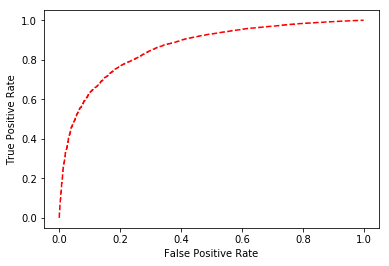

In [245]:
y_pred = model.predict_proba(w2v_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

ROC Score 0.86208826601


[[ 1867  1944]
 [ 1760 24429]]


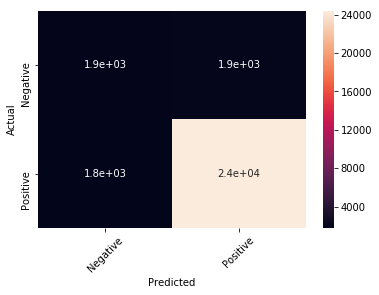

In [246]:
print('ROC Score',roc_auc_score(y_true,y_pred))
print('\n')
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<h3>Logistic Regression on Avg-w2vec with L2</h3>
* Optimal C = 1
* Accuracy = 87.65
* Precision = 0.92(positive), 0.51(negative)
* Recall = 0.93 ,0.48
* AUC = 0.86
* TN = 1867
* TP = 24429


In [247]:
clf = LogisticRegression(C = 1 ,class_weight = 'balanced')
clf.fit(w2v_train,y_train)
w_w2v = clf.coef_
w2v_train.data = w2v_train.data + rand

[[ 0.37076776 -0.2148152   0.14269326  0.29113094 -0.59125307 -0.39804974
  -0.06537678 -0.12409628  0.20793493  0.213885    0.61894019  0.0363619
  -0.03263522 -0.0424642  -0.4021873   0.11352239  0.23690437 -0.13912004
   0.32178556 -0.06122943  0.22543433  0.41542861  0.1521852   0.25600009
   0.21987274  0.08733047 -0.45796842  0.47672939  0.08620495 -0.1207968
  -0.28588186 -0.15767357 -0.33171879 -0.30709415 -0.80752824 -0.12577033
  -0.35393806 -0.14555453 -0.18355871  0.40295549 -0.15255126  0.02824109
  -0.34163162  0.07688974  0.09728864 -0.38529685 -0.14788566 -0.42100114
   0.62512785 -0.4994952 ]]


# Multicollinearity check

In [248]:
mod  = GridSearchCV(LogisticRegression(class_weight = 'balanced'),tunned_param , scoring = 'accuracy',cv = 10,n_jobs = -1)
mod.fit(w2v_train,y_train)
print(mod.best_estimator_)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [249]:
clf_noise = LogisticRegression(class_weight = 'balanced',C = 1)
clf_noise.fit(w2v_train,y_train)
w_ = clf_noise.coef_

[[ 0.37074169 -0.21480769  0.14271536  0.29113785 -0.59122114 -0.39802131
  -0.06539209 -0.12408598  0.20794021  0.21387863  0.61894129  0.0363702
  -0.03264708 -0.04245962 -0.40218067  0.11351973  0.23688174 -0.13912112
   0.32180065 -0.06119811  0.22544015  0.41544074  0.15219955  0.25602352
   0.21988354  0.08731498 -0.45795553  0.47673351  0.08619895 -0.12079157
  -0.28587255 -0.15766967 -0.33169755 -0.3070821  -0.80750977 -0.12576439
  -0.35391471 -0.14552967 -0.18356721  0.40294866 -0.1525602   0.02822693
  -0.34162572  0.07689781  0.09730443 -0.38530197 -0.14786992 -0.42098223
   0.6251021  -0.49948318]]


In [250]:
w_per = ((w_ - w_w2v)/abs(w_w2v))
w_per = abs(w_per)[0]
ch_w = []
for i in w_per:
    if i > 0.3:
        ch_w.append(i)

In [252]:
print(len(ch_w))
print(len(w_per))
print(print('Multicollinearity exists in features for change greater than 30% is',(len(ch_w)/len(w_per))*100,'%'))

0
50
Multicollinearity exists in features for change greater than 30% is 0.0 %
None


In [253]:
ch_w = []
for i in w_per:
    if i > 0.4:
        ch_w.append(i)

In [255]:
print(len(ch_w))
print(len(w_per))
print(print('Multicollinearity exists in features for change greater than 40% is',(len(ch_w)/len(w_per))*100,'%'))

0
50
Multicollinearity exists in features for change greater than 40% is 0.0 %
None


<h4>Top 10 features</h4>

In [256]:
sr = sorted(w_w2v)[0]
print(sr[::-1][:10])

[-0.4994952   0.62512785 -0.42100114 -0.14788566 -0.38529685  0.09728864
  0.07688974 -0.34163162  0.02824109 -0.15255126]


# Logistic Regression on Tfidf W2Vec

In [261]:
tf_idf_feat = tfidf_vect.get_feature_names()
tfidf_sent_vec_train = []
row = 0
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_train[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec/= weight_sum
    tfidf_sent_vec_train.append(sent_vec)
    row += 1


In [262]:
tf_idf_feat = tfidf_vect.get_feature_names()
tfidf_sent_vec_test = []
row = 0
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_test[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec/= weight_sum
    tfidf_sent_vec_test.append(sent_vec)
    row += 1


In [263]:
np.where(np.isnan(tfidf_sent_vec_train))

(array([], dtype=int64), array([], dtype=int64))

In [264]:
#del tfidf_sent_vec_train[10706]

In [265]:
#y_train = np.delete(y_train,10706)

In [266]:
sc =  StandardScaler()
tfidf_w2v_train = sc.fit_transform(tfidf_sent_vec_train)
tfidf_w2v_test = sc.transform(tfidf_sent_vec_test)
param = [{'C':[10**i for i in range(-3,4)]}]
wv_model = GridSearchCV(LogisticRegression(class_weight = 'balanced',penalty = 'l1'),param,scoring = 'accuracy',cv = 10,n_jobs = -1,)
wv_model.fit(tfidf_w2v_train,y_train)
print(wv_model.best_estimator_)
pred = wv_model.predict(tfidf_w2v_test)
acc = accuracy_score(y_test,pred)
print('accuracy is',acc*100)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
accuracy is 76.4133333333


In [267]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))
print('\n')
print('Recall for positive',recall_score(y_test,pred,pos_label = 'positive'))
print('Recall for negative',recall_score(y_test,pred,pos_label = 'negative'))
print('\n')
print('Precision for postive',precision_score(y_test,pred,pos_label = 'positive'))
print('Precision for negative',precision_score(y_test,pred,pos_label = 'negative'))


             precision    recall  f1-score   support

   negative       0.33      0.80      0.46      3811
   positive       0.96      0.76      0.85     26189

avg / total       0.88      0.76      0.80     30000



Recall for positive 0.758906411089
Recall for negative 0.800052479664


Precision for postive 0.963076028493
Precision for negative 0.325643490334


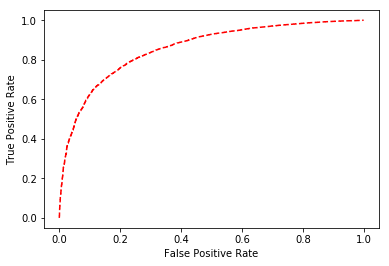

In [268]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred = wv_model.predict_proba(tfidf_w2v_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

ROC Score 0.858007651002


[[ 3049   762]
 [ 6314 19875]]


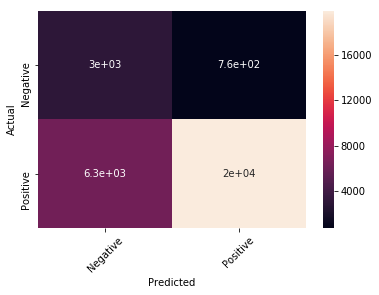

In [269]:
print('ROC Score',roc_auc_score(y_true,y_pred))
print('\n')
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<h3>Logistic Regression on Tfidf-w2vec with L1</h3>
* Optimal C = 0.1
* Accuracy = 79.41
* Precision = 0.96(positive), 0.32(negative)
* Recall = 0.75 ,0.80
* AUC = 0.85
* TN = 3049
* TP = 19875


In [270]:
lr_clf = LogisticRegression(penalty = 'l1', C = 0.1,class_weight = 'balanced')
lr_clf.fit(tfidf_w2v_train,y_train)
pred = lr_clf.predict(tfidf_w2v_test)
pred_train = lr_clf.predict(tfidf_w2v_train)
test_error = 1-accuracy_score(y_test,pred)
train_error = 1-accuracy_score(y_train,pred_train)

In [271]:
print('Error on test',test_error*100)
print('Error on train',train_error*100)
w = lr_clf.coef_
print('Sparsity',np.count_nonzero(w)-len(w))

Error on test 23.5866666667
Error on train 23.6903384334
Sparsity 48


In [272]:
lr_clf = LogisticRegression(penalty = 'l1', C = 1,class_weight = 'balanced')
lr_clf.fit(tfidf_w2v_train,y_train)
pred = lr_clf.predict(tfidf_w2v_test)
pred_train = lr_clf.predict(tfidf_w2v_train)
test_error = 1-accuracy_score(y_test,pred)
train_error = 1-accuracy_score(y_train,pred_train)

In [273]:
print('Error on test',test_error*100)
print('Error on train',train_error*100)
w = lr_clf.coef_
print('Sparsity',np.count_nonzero(w)-len(w))

Error on test 23.5566666667
Error on train 23.6774811069
Sparsity 49


In [274]:
lr_clf = LogisticRegression(penalty = 'l1', C = 10,class_weight = 'balanced')
lr_clf.fit(tfidf_w2v_train,y_train)
pred = lr_clf.predict(tfidf_w2v_test)
pred_train = lr_clf.predict(tfidf_w2v_train)
test_error = 1-accuracy_score(y_test,pred)
train_error = 1-accuracy_score(y_train,pred_train)

In [275]:
print('Error on test',test_error*100)
print('Error on train',train_error*100)
w = lr_clf.coef_
print('Sparsity',np.count_nonzero(w)-len(w))

Error on test 23.5433333333
Error on train 23.6774811069
Sparsity 49


In [276]:
lr_clf = LogisticRegression(penalty = 'l1', C = 100,class_weight = 'balanced')
lr_clf.fit(tfidf_w2v_train,y_train)
pred = lr_clf.predict(tfidf_w2v_test)
pred_train = lr_clf.predict(tfidf_w2v_train)
test_error = 1-accuracy_score(y_test,pred)
train_error = 1-accuracy_score(y_train,pred_train)

In [277]:
print('Error on test',test_error*100)
print('Error on train',train_error*100)
w = lr_clf.coef_
print('Sparsity',np.count_nonzero(w)-len(w))

Error on test 23.5433333333
Error on train 23.6789096987
Sparsity 49


# Result with L1
1. C = 0.1 , ERROR ON TEST - 23.58 , ERROR IN TRAIN - 23.69 , SPARSITY - 48
2. C = 1 , ERROR ON TEST - 23.55 , ERROR IN TRAIN - 23.67 , SPARSITY - 49
3. C = 10 , ERROR ON TEST - 23.54 , ERROR IN TRAIN - 23.67 , SPARSITY - 49
4. C = 100 , ERROR ON TEST - 23.54 , ERROR IN TRAIN - 23.67 , SPARSITY - 49

In [278]:
model  = GridSearchCV(LogisticRegression(class_weight = 'balanced'),param , scoring = 'accuracy',cv = 10,n_jobs = -1)
model.fit(tfidf_w2v_train,y_train)
print(model.best_estimator_)
pred = model.predict(tfidf_w2v_test)
print('Accuracy ',accuracy_score(y_test,pred)*100)

LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy  76.4533333333


In [279]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))
print('\n')
print('Recall for positive',recall_score(y_test,pred,pos_label = 'positive'))
print('Recall for negative',recall_score(y_test,pred,pos_label = 'negative'))
print('\n')
print('Precision for postive',precision_score(y_test,pred,pos_label = 'positive'))
print('Precision for negative',precision_score(y_test,pred,pos_label = 'negative'))


             precision    recall  f1-score   support

   negative       0.33      0.80      0.46      3811
   positive       0.96      0.76      0.85     26189

avg / total       0.88      0.76      0.80     30000



Recall for positive 0.759364618733
Recall for negative 0.800052479664


Precision for postive 0.963097486561
Precision for negative 0.326061383809


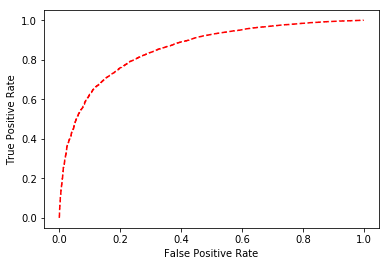

In [280]:
change = lambda x : 1 if x == 'positive' else 0
y_true = np.array([change(x) for x in y_test])
y_pred = model.predict_proba(tfidf_w2v_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

ROC Score 0.858033961971


[[ 3049   762]
 [ 6302 19887]]


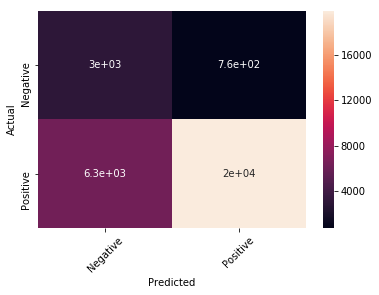

In [281]:
print('ROC Score',roc_auc_score(y_true,y_pred))
print('\n')
confusion = confusion_matrix(y_test , pred)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<h3>Logistic Regression on Tfidf-w2vec with L2</h3>
* Optimal C = 10
* Accuracy = 76.45
* Precision = 0.96(positive), 0.32(negative)
* Recall = 0.75 ,0.80
* AUC = 0.85
* TN = 3049
* TP = 19887


In [282]:
clf = LogisticRegression(C = 10 ,class_weight = 'balanced')
clf.fit(tfidf_w2v_train,y_train)
w_tw = clf.coef_
print(w_tw)


[[ 0.02227554  0.24687819  0.37823166  0.57594705 -0.37873557  0.02131065
   0.41199441 -0.35374098 -0.07554398 -0.10735884  0.35796675 -0.1786271
   0.35220381  0.11873004 -0.60147544 -0.33643168  0.21301264 -0.02092132
   0.8381591   0.04104244  0.31729943 -0.09284939  0.51619522  0.58721911
   0.16106774 -0.03312721 -0.29633354  0.38546997 -0.6728411  -0.05190695
  -0.06456107 -0.18990998 -0.58129387 -0.46385552 -0.15921694 -0.04961211
   0.07228252 -0.04166887 -0.17267261  0.23475067 -0.0980782   0.5319953
  -0.18634539  0.29089368  0.14593808 -0.28221459 -0.09264809  0.01435754
   0.5253343  -0.48866339]]


# Multicollinearity check

In [283]:
tfidf_w2v_train.data = tfidf_w2v_train.data + rand

In [284]:
mod_no  = GridSearchCV(LogisticRegression(class_weight = 'balanced'),tunned_param , scoring = 'accuracy',cv = 10,n_jobs = -1)
mod_no.fit(tfidf_w2v_train,y_train)
print(mod_no.best_estimator_)

LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [285]:
clf_no = LogisticRegression(class_weight = 'balanced',C = 100)
clf_no.fit(tfidf_w2v_train,y_train)
w_wtf = clf_no.coef_
print(w_wtf)

[[ 0.02227798  0.2469405   0.37827323  0.57593362 -0.37875142  0.02134413
   0.41202389 -0.35377543 -0.07555119 -0.10733927  0.35800868 -0.17865769
   0.35222731  0.11876977 -0.6015311  -0.33645107  0.21307016 -0.02094291
   0.83826889  0.04105077  0.31733588 -0.09290468  0.51623758  0.58727585
   0.16108844 -0.03314105 -0.29636022  0.3854946  -0.67294777 -0.05192312
  -0.06457251 -0.18989387 -0.58131874 -0.46386346 -0.15919052 -0.04958319
   0.07229074 -0.04170776 -0.17267676  0.2348406  -0.09809837  0.53205607
  -0.1863495   0.29092362  0.14590847 -0.28223304 -0.09264245  0.0144172
   0.52538131 -0.48870019]]


In [286]:
wtf_per = ((w_wtf - w_tw)/abs(w_tw))
wtf_per = abs(wtf_per)[0]
print(wtf_per)
ch_wtf = []
for i in wtf_per:
    if i > 0.3:
        ch_wtf.append(i)

[  1.09822497e-04   2.52366338e-04   1.09911554e-04   2.33259080e-05
   4.18341479e-05   1.57098133e-03   7.15593607e-05   9.73690660e-05
   9.53398298e-05   1.82255387e-04   1.17134438e-04   1.71240654e-04
   6.67344312e-05   3.34591349e-04   9.25333561e-05   5.76574121e-05
   2.70000531e-04   1.03194882e-03   1.30985958e-04   2.02880216e-04
   1.14865993e-04   5.95412093e-04   8.20600471e-05   9.66239089e-05
   1.28513274e-04   4.17729780e-04   9.00062465e-05   6.38805811e-05
   1.58544089e-04   3.11565842e-04   1.77207071e-04   8.48254522e-05
   4.27799415e-05   1.71053273e-05   1.65953184e-04   5.82769907e-04
   1.13723288e-04   9.33269889e-04   2.40314159e-05   3.83092080e-04
   2.05589943e-04   1.14221496e-04   2.20758018e-05   1.02915392e-04
   2.02901015e-04   6.53562489e-05   6.08768805e-05   4.15526724e-03
   8.94889490e-05   7.53096503e-05]


In [288]:
print(len(ch_wtf))
print(len(wtf_per))
print(print('Multicollinearity exists in features for change greater than 30% is',(len(ch_wtf)/len(wtf_per))*100,'%'))

0
50
Multicollinearity exists in features for change greater than 30% is 0.0 %
None


In [289]:
ch_wtf = []
for i in wtf_per:
    if i > 0.4:
        ch_wtf.append(i)

In [291]:
print(len(ch_wtf))
print(len(wtf_per))
print(print('Multicollinearity exists in features for change greater than 40% is',(len(ch_wtf)/len(wtf_per))*100,'%'))

0
50
Multicollinearity exists in features for change greater than 40% is 0.0 %
None


<h4>Top 10 features</h4>

In [292]:
sort = sorted(w_tw)[0]
print(sort[::-1][:10])

[-0.48866339  0.5253343   0.01435754 -0.09264809 -0.28221459  0.14593808
  0.29089368 -0.18634539  0.5319953  -0.0980782 ]
